In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches

from astropy import coordinates
from astropy import units as u
from astropy.io import fits

from shapely import geometry
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch

from skipper import observe

In [2]:
plt.rcParams['font.size'] = 20

In [3]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

In [4]:
edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
cosmos_area = geometry.Polygon ( edges )

In [5]:
circle_radius = (3.18/np.pi)**0.5

In [8]:
def _make_grid ( ngridstep, nexp, extent=2.5):
    gra_a = np.linspace(center.ra.deg - extent,  center.ra.deg  + extent, ngridstep)
    gdec_a = np.linspace(center.dec.deg- extent,  center.dec.deg + extent, ngridstep)

    step = np.diff(gra_a)[0]

    pl_l = []
    for cra in gra_a:
        for cdec in gdec_a:
            pl_l.append ( Point ( cra, cdec ).buffer ( step ) )

    grid = np.zeros([nexp,ngridstep,ngridstep])  
    return grid, pl_l, gra_a, gdec_a

def compute_coverage ( src_grid, nexp, radii):
    if not hasattr(radii, '__len__'): # i.e. if not list-like
        radii = [size[0] * radii]
        
    grid = src_grid.copy()

    nrad = len(radii)
    nexp_per_rad = nexp / nrad
    assert nexp % nrad == 0
    
    theta_a = np.linspace(0, np.pi*2, nexp_per_rad+1)[:-1]
    centers = np.zeros ( [nexp, 2] )
    area_a = np.zeros(nexp)
    poly_l = []
    ii=0
    for rd in radii:
        for ita in theta_a:
            dely = rd * np.sin ( ita ) 
            delx = rd * np.cos ( ita ) 
            centers[ii,0] = center.ra.deg + delx
            centers[ii,1] = center.dec.deg + dely

            dfov = Point ( centers[ii,0], centers[ii,1] ).buffer ( circle_radius )
            iarea = cosmos_area.intersection ( dfov )
            area_a[ii] = iarea.area
            poly_l.append(dfov)

            aa = [ dfov.contains ( pl_l[ix] ) for ix in range(len(pl_l)) ] 
            grid[ii, np.asarray(aa).reshape(grid.shape[1:])] = 1
            ii+=1
    return grid, poly_l, area_a, centers

In [125]:
nexp = 40
grid, pl_l, gra_a, gdec_a = _make_grid ( 100, nexp )

radii_a = np.arange(0.,1.01,.1)
ovl_grid_a = np.zeros([len(radii_a), grid.shape[1], grid.shape[2]])
mpoly_l = []
for ix,rd in enumerate(radii_a):
    cgrid, poly_l, area_a, centers = compute_coverage ( grid, nexp, rd )
    ovl_grid_a[ix] = cgrid.sum(axis=0)
    mpoly_l.append(unary_union ( poly_l ))


/Users/kadofong/env3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [126]:
RA,DEC = np.meshgrid ( gra_a, gdec_a )

in_cosmos = (RA >= (center.ra.deg - size[0]/2))&(RA <= (center.ra.deg + size[0]/2))
in_cosmos &= (DEC >= (center.dec.deg - size[1]/2))&(DEC <= (center.dec.deg + size[1]/2))

In [186]:
for ix in range(ovl_grid_a.shape[0]):
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111, aspect='equal')
    plt.pcolormesh(gra_a - np.diff(gra_a)[0]*.5, 
                   gdec_a - np.diff(gdec_a)[0]*.5, 
                   ovl_grid_a[ix], vmax=40, vmin=0)
    rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                              width = size[0], 
                              height= size[1],
                             fc='None', ec='w', )
    ax.add_patch (rect)
    ax.text ( .95, 0.95, r'$\Delta$R=%.2f deg' % (radii_a[ix]*size[0]), ha='right', va='top', color='white', 
            fontsize=20, transform=ax.transAxes )
    plt.colorbar(label=r'$\rm N_{exp}$')
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel ( "Dec (deg)")

    plt.savefig(f'../../scratch/figs/{ix:04d}.png')
    plt.close()


In [154]:
radii_a

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

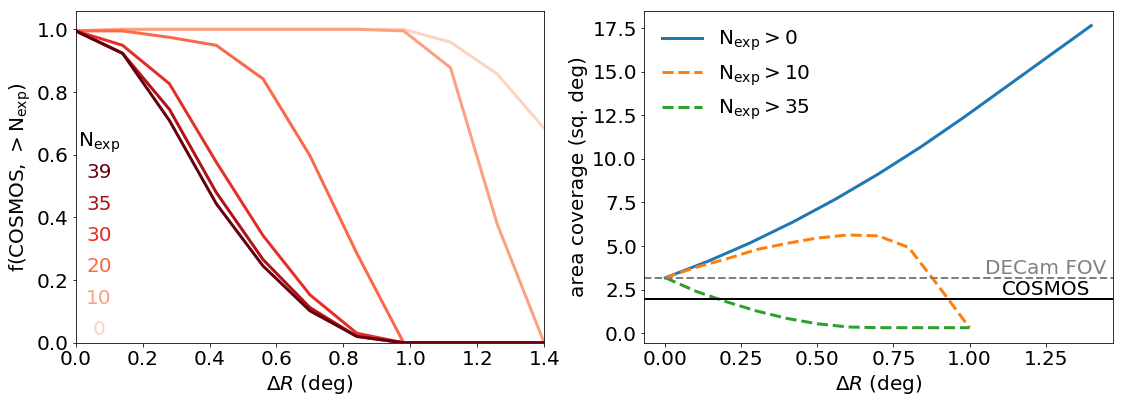

In [182]:
fig, axarr = plt.subplots(1,2,figsize=(16,6))


ax = axarr[0]

for ix,cnexp in enumerate([0, 10, 20, 30, 35, 39]):
    cy = (ovl_grid_a[:,in_cosmos] > cnexp).sum(axis=1)/in_cosmos.sum()
    color = plt.cm.Reds ( (ix+1) / 6 )
    ax.plot( radii_a*size[0], cy, lw=3,
           color=color )
    ax.text ( 0.07, .025+.1*ix, cnexp, color=color, ha='center' )
    
ax.text ( 0.07, 0.025+.1*(ix+1), r'$\rm N_{exp}$', ha='center')   
ax.set_xlabel ( r'$\Delta R$ (deg)' )
ax.set_ylabel (r'f(COSMOS, $\rm >N_{exp}$)')

ax.set_xlim(0., radii_a[-1]*size[0])
ax.set_ylim(0.,1.06)

ax = axarr[1]
rastep  = np.diff(gra_a)[0]
decstep = np.diff(gdec_a)[0]



ax.plot ( radii_a*size[0], [mp.area for mp in mpoly_l], lw=3, label = r'$\rm N_{exp} > 0$' )

for cnexp in [10,35]:
    fcoverage = (ovl_grid_a>cnexp).sum(axis=1).sum(axis=1)*rastep*decstep
    fcoverage += 3.18 - fcoverage[0] # tweak for finite grid size
    ax.plot( radii_a, fcoverage, lw=3, ls='--', label = r'$\rm N_{exp} > %i$'%cnexp )

ax.axhline ( size[0]*size[1], color='k', lw=2 )
ax.text ( 1.25, size[0]*size[1]+0.01, 'COSMOS', ha='center', va='bottom' )
ax.axhline ( 3.18, color='grey', lw=2, ls='--' )
ax.text ( 1.25, 3.19, 'DECam FOV', ha='center', va='bottom', color='grey' )
ax.set_xlabel ( r'$\Delta R$ (deg)' )
ax.set_ylabel ( 'area coverage (sq. deg)' )
ax.legend(frameon=False)

plt.tight_layout ()
plt.savefig('../../scratch/figs/COSMOScoverage.png')

Text(0,0.5,'area coverage (sq. deg)')

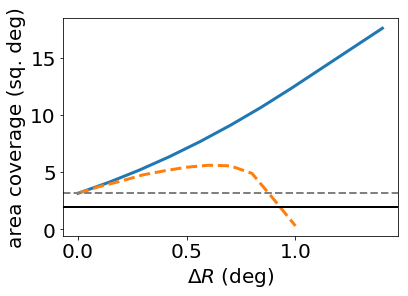

In [ ]:
plt.figure(figsize=(8,6))
bins = np.arange(0,42,1)

for ix in range(ovl_grid_a.shape[0]):
    plt.hist ( ovl_grid_a[-ix,in_cosmos].flatten(), bins=bins, cumulative=True,
              color=plt.cm.Blues_r ( (ix+1)/ovl_grid_a.shape[0] ), lw=2, zorder=0 )
    
plt.xlim(0.,40)
plt.ylim(0, in_cosmos.sum())

plt.xlabel ( r'exposure count')
plt.ylabel ( "CDF")

Text(0,0.5,'Dec (deg)')

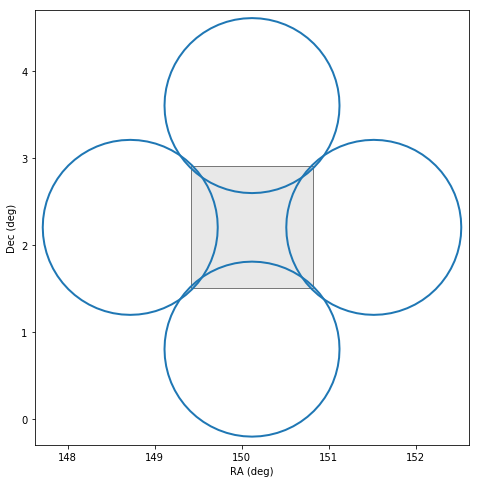

In [53]:
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(nexp):
    patch = PolygonPatch ( poly_l[ij], fc='None', ec='tab:blue', lw=2, )
    ax.add_patch(patch)

ax.set_xlim ( center.ra.deg - 2.5,  center.ra.deg  + 2.5)
ax.set_ylim ( center.dec.deg- 2.5,  center.dec.deg + 2.5)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')